In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_excel('POST 1-31 Jul Twitter Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-07-10 23:59:48+00:00,1546283073871811072,reenpur78,1487473982290812928,1.546183e+18,sbebme,0,@sbebme @JadaSchwitz Did u step on a bee again...
1,1,2022-07-10 23:59:39+00:00,1546283039965097984,KevinSipos2,1438765619931803904,1.546282e+18,grannydryden1,0,@grannydryden1 @Jar81Jar @laura_auerbach @Patr...
2,2,2022-07-10 23:58:03+00:00,1546282633855901952,S_7_3_V_3,1516902469724519936,1.546281e+18,FoxNews,0,@FoxNews She's got an Amber Heard look about her!
3,3,2022-07-10 23:57:21+00:00,1546282457292591104,Daniboy_CFC,259698028,NaN,NaN,0,Johnny Depp Releases New Music Which Seemingly...
4,4,2022-07-10 23:57:07+00:00,1546282401755762944,9breakingn,1514195915338567936,NaN,NaN,0,Johnny Depp seemingly lashes out at ex-wife Am...


In [3]:
df = tweets.filter(['full_text', "created_at"], axis=1)
df2 = df.dropna()
df2.head()

,full_text,created_at
0,@sbebme @JadaSchwitz Did u step on a bee again...,2022-07-10 23:59:48+00:00
1,@grannydryden1 @Jar81Jar @laura_auerbach @Patr...,2022-07-10 23:59:39+00:00
2,@FoxNews She's got an Amber Heard look about her!,2022-07-10 23:58:03+00:00
3,Johnny Depp Releases New Music Which Seemingly...,2022-07-10 23:57:21+00:00
4,Johnny Depp seemingly lashes out at ex-wife Am...,2022-07-10 23:57:07+00:00


# Data cleaning

In [4]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [5]:
df2.head()

,full_text,created_at,clean_text
0,@sbebme @JadaSchwitz Did u step on a bee again...,2022-07-10 23:59:48+00:00,"[u, step, bee, abuser]"
1,@grannydryden1 @Jar81Jar @laura_auerbach @Patr...,2022-07-10 23:59:39+00:00,"[well, doubt, victim, would, support]"
2,@FoxNews She's got an Amber Heard look about her!,2022-07-10 23:58:03+00:00,"[got, look]"
3,Johnny Depp Releases New Music Which Seemingly...,2022-07-10 23:57:21+00:00,"[releases, new, music, seemingly, bashes]"
4,Johnny Depp seemingly lashes out at ex-wife Am...,2022-07-10 23:57:07+00:00,"[seemingly, lashes, ex, wife, two, devastating..."


In [6]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
0,@sbebme @JadaSchwitz Did u step on a bee again...,2022-07-10 23:59:48+00:00,"[step, bee, abuser]"
1,@grannydryden1 @Jar81Jar @laura_auerbach @Patr...,2022-07-10 23:59:39+00:00,[victim]
2,@FoxNews She's got an Amber Heard look about her!,2022-07-10 23:58:03+00:00,[]
3,Johnny Depp Releases New Music Which Seemingly...,2022-07-10 23:57:21+00:00,[music]
4,Johnny Depp seemingly lashes out at ex-wife Am...,2022-07-10 23:57:07+00:00,"[ex, wife, song]"


In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


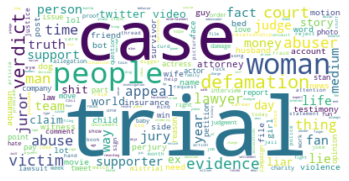

In [8]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

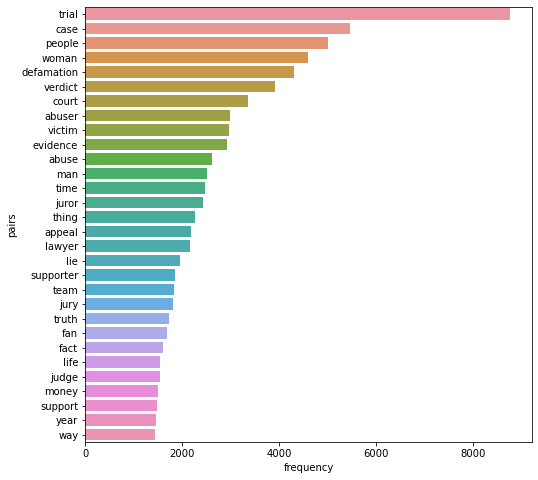

In [9]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [10]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['step', 'bee', 'abuser'], ['victim'], []]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'abuser'), (1, 'bee'), (2, 'step'), (3, 'victim'), (4, 'music'), (5, 'ex'), (6, 'song'), (7, 'wife'), (8, 'trial'), (9, 'u'), (10, 'amount'), (11, 'hatred'), (12, 'lot'), (13, 'man'), (14, 'misogyny'), (15, 'people'), (16, 'saga'), (17, 'setback'), (18, 'shit'), (19, 'attorney'), (20, 'court'), (21, 'declare'), (22, 'defamation'), (23, 'filing'), (24, 'order'), (25, 'allegation'), (26, 'benefit'), (27, 'colour'), (28, 'defender'), (29, 'inch'), (30, 'proof'), (31, 'purpose'), (32, 'supporter'), (33, 'tension'), (34, 'woman'), (35, 'fun'), (36, 'monetize'), (37, 'simp'), (38, 'video'), (39, 'weirdo'), (40, 'name'), (41, 'lawyer'), (42, 'lie'), (43, 'stop'), (44, 'taunting'), (45, 'trash'), (46, 'manipulation'), (47, 'manipulator'), (48, 'r'), (49, 'relationship')]

Total Vocabulary Size: 6971


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [13]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.5605178674238518
Perplexity Score:  -6.8720591624719685

topic number:  3
Coherence Score:  0.44241885169771183
Perplexity Score:  -6.906546968153413

topic number:  4
Coherence Score:  0.40349322564312784
Perplexity Score:  -6.989123473855744

topic number:  5
Coherence Score:  0.426933306488127
Perplexity Score:  -7.024917424544524

topic number:  6
Coherence Score:  0.3903868991914889
Perplexity Score:  -7.0491417658539754

topic number:  7
Coherence Score:  0.38564702244173255
Perplexity Score:  -7.105247072218625

topic number:  8
Coherence Score:  0.40764092345054653
Perplexity Score:  -7.116413451741539

topic number:  9
Coherence Score:  0.36843665075169885
Perplexity Score:  -7.192428779306106

topic number:  10
Coherence Score:  0.3369251469860927
Perplexity Score:  -7.321894846518404

topic number:  11
Coherence Score:  0.3283156946246604
Perplexity Score:  -7.637272499817592

topic number:  12
Coherence Score:  0.32881254512588504
Perple

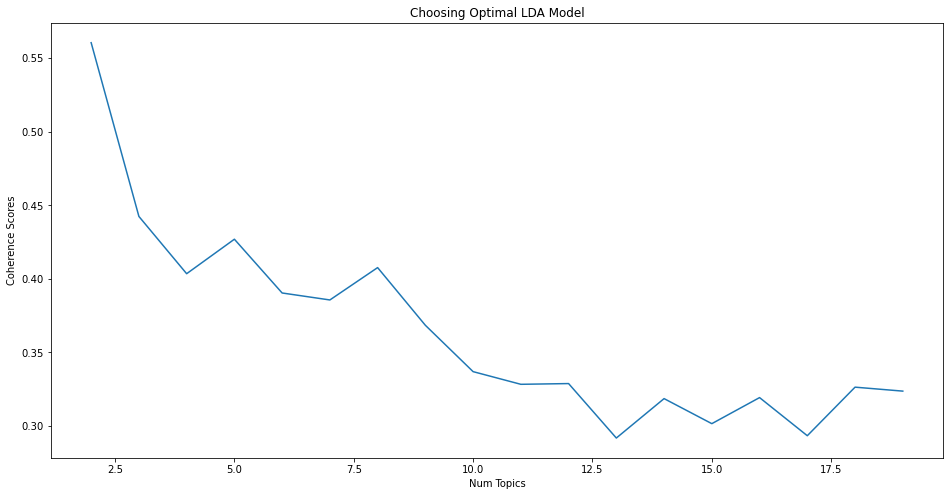

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [47]:
ntopics_des_name = 5
# Even though 2 has the highest coherence score, we decided to choose 5 as it is another number that is another number before a major drop.
# When we run the code using 2 topics, the results are too broad and it was difficult to draw any insights from the results.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [48]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.124*"trial" + 0.087*"case" + 0.077*"verdict" + 0.070*"defamation" + '
  '0.050*"court" + 0.036*"appeal" + 0.035*"lawyer" + 0.027*"jury" + '
  '0.027*"juror" + 0.021*"judge"'),
 (1,
  '0.045*"woman" + 0.042*"man" + 0.027*"truth" + 0.026*"fan" + 0.023*"money" + '
  '0.020*"medium" + 0.019*"time" + 0.016*"thing" + 0.015*"year" + 0.012*"day"'),
 (2,
  '0.062*"evidence" + 0.016*"shit" + 0.016*"supporter" + 0.016*"lol" + '
  '0.014*"bed" + 0.014*"fact" + 0.014*"witness" + 0.013*"photo" + '
  '0.012*"document" + 0.010*"testimony"'),
 (3,
  '0.058*"people" + 0.038*"abuser" + 0.037*"victim" + 0.032*"abuse" + '
  '0.024*"woman" + 0.018*"support" + 0.016*"person" + 0.014*"lie" + '
  '0.013*"life" + 0.012*"twitter"'),
 (4,
  '0.028*"movie" + 0.024*"aquaman" + 0.023*"wife" + 0.020*"petition" + '
  '0.019*"pay" + 0.019*"perjury" + 0.016*"ex" + 0.015*"actor" + 0.015*"right" '
  '+ 0.014*"sign"')]


In [49]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [50]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [51]:
df2['Topic'] = topic_num

In [52]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,@sbebme @JadaSchwitz Did u step on a bee again...,"[step, bee, abuser]","[3, 1, 4, 0, 2]"
1,@grannydryden1 @Jar81Jar @laura_auerbach @Patr...,[victim],"[3, 4, 0, 1, 2]"
2,@FoxNews She's got an Amber Heard look about her!,[],"[0, 1, 2, 3, 4]"
3,Johnny Depp Releases New Music Which Seemingly...,[music],"[1, 4, 2, 0, 3]"
4,Johnny Depp seemingly lashes out at ex-wife Am...,"[ex, wife, song]","[4, 0, 1, 2, 3]"


### Model Evaluation

In [53]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.000124356685659
Coherence Score:  0.4446019623739007


## Visualisation

In [54]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.203435 -0.031788       1        1  26.184878
0     -0.305769 -0.278818       2        1  21.038369
1      0.192986  0.029480       3        1  20.792995
2      0.140136 -0.052830       4        1  17.872322
4     -0.230788  0.333955       5        1  14.111436, topic_info=           Term         Freq        Total Category  logprob  loglift
8         trial  7883.000000  7883.000000  Default  30.0000  30.0000
96         case  5526.000000  5526.000000  Default  29.0000  29.0000
58      verdict  4929.000000  4929.000000  Default  28.0000  28.0000
22   defamation  4490.000000  4490.000000  Default  27.0000  27.0000
15       people  4573.000000  4573.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
402     perjury   798.166305   991.059477   Topic5  -3.9823   1.7417
733     actress   518.383848   636.860260   Topic5  -4.4139   1.7524
5            ex   706.300435  1114.112009   Topic5  -4.1045   1.5024
201        news   540.541770   836.139022   Topic5  -4.3720   1.5220
89      husband   436.648344   874.060597   Topic5  -4.5855   1.2642

[247 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
145       1  0.999817    abuse
0         1  0.999825   abuser
496       1  0.998812  account
808       5  0.998268   action
105       5  0.998584    actor
...     ...       ...      ...
111       1  0.723031    world
111       3  0.275905    world
949       3  0.997779       ye
75        1  0.305446     year
75        3  0.694062     year

[260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5])

## Word Count of Topic Keywords

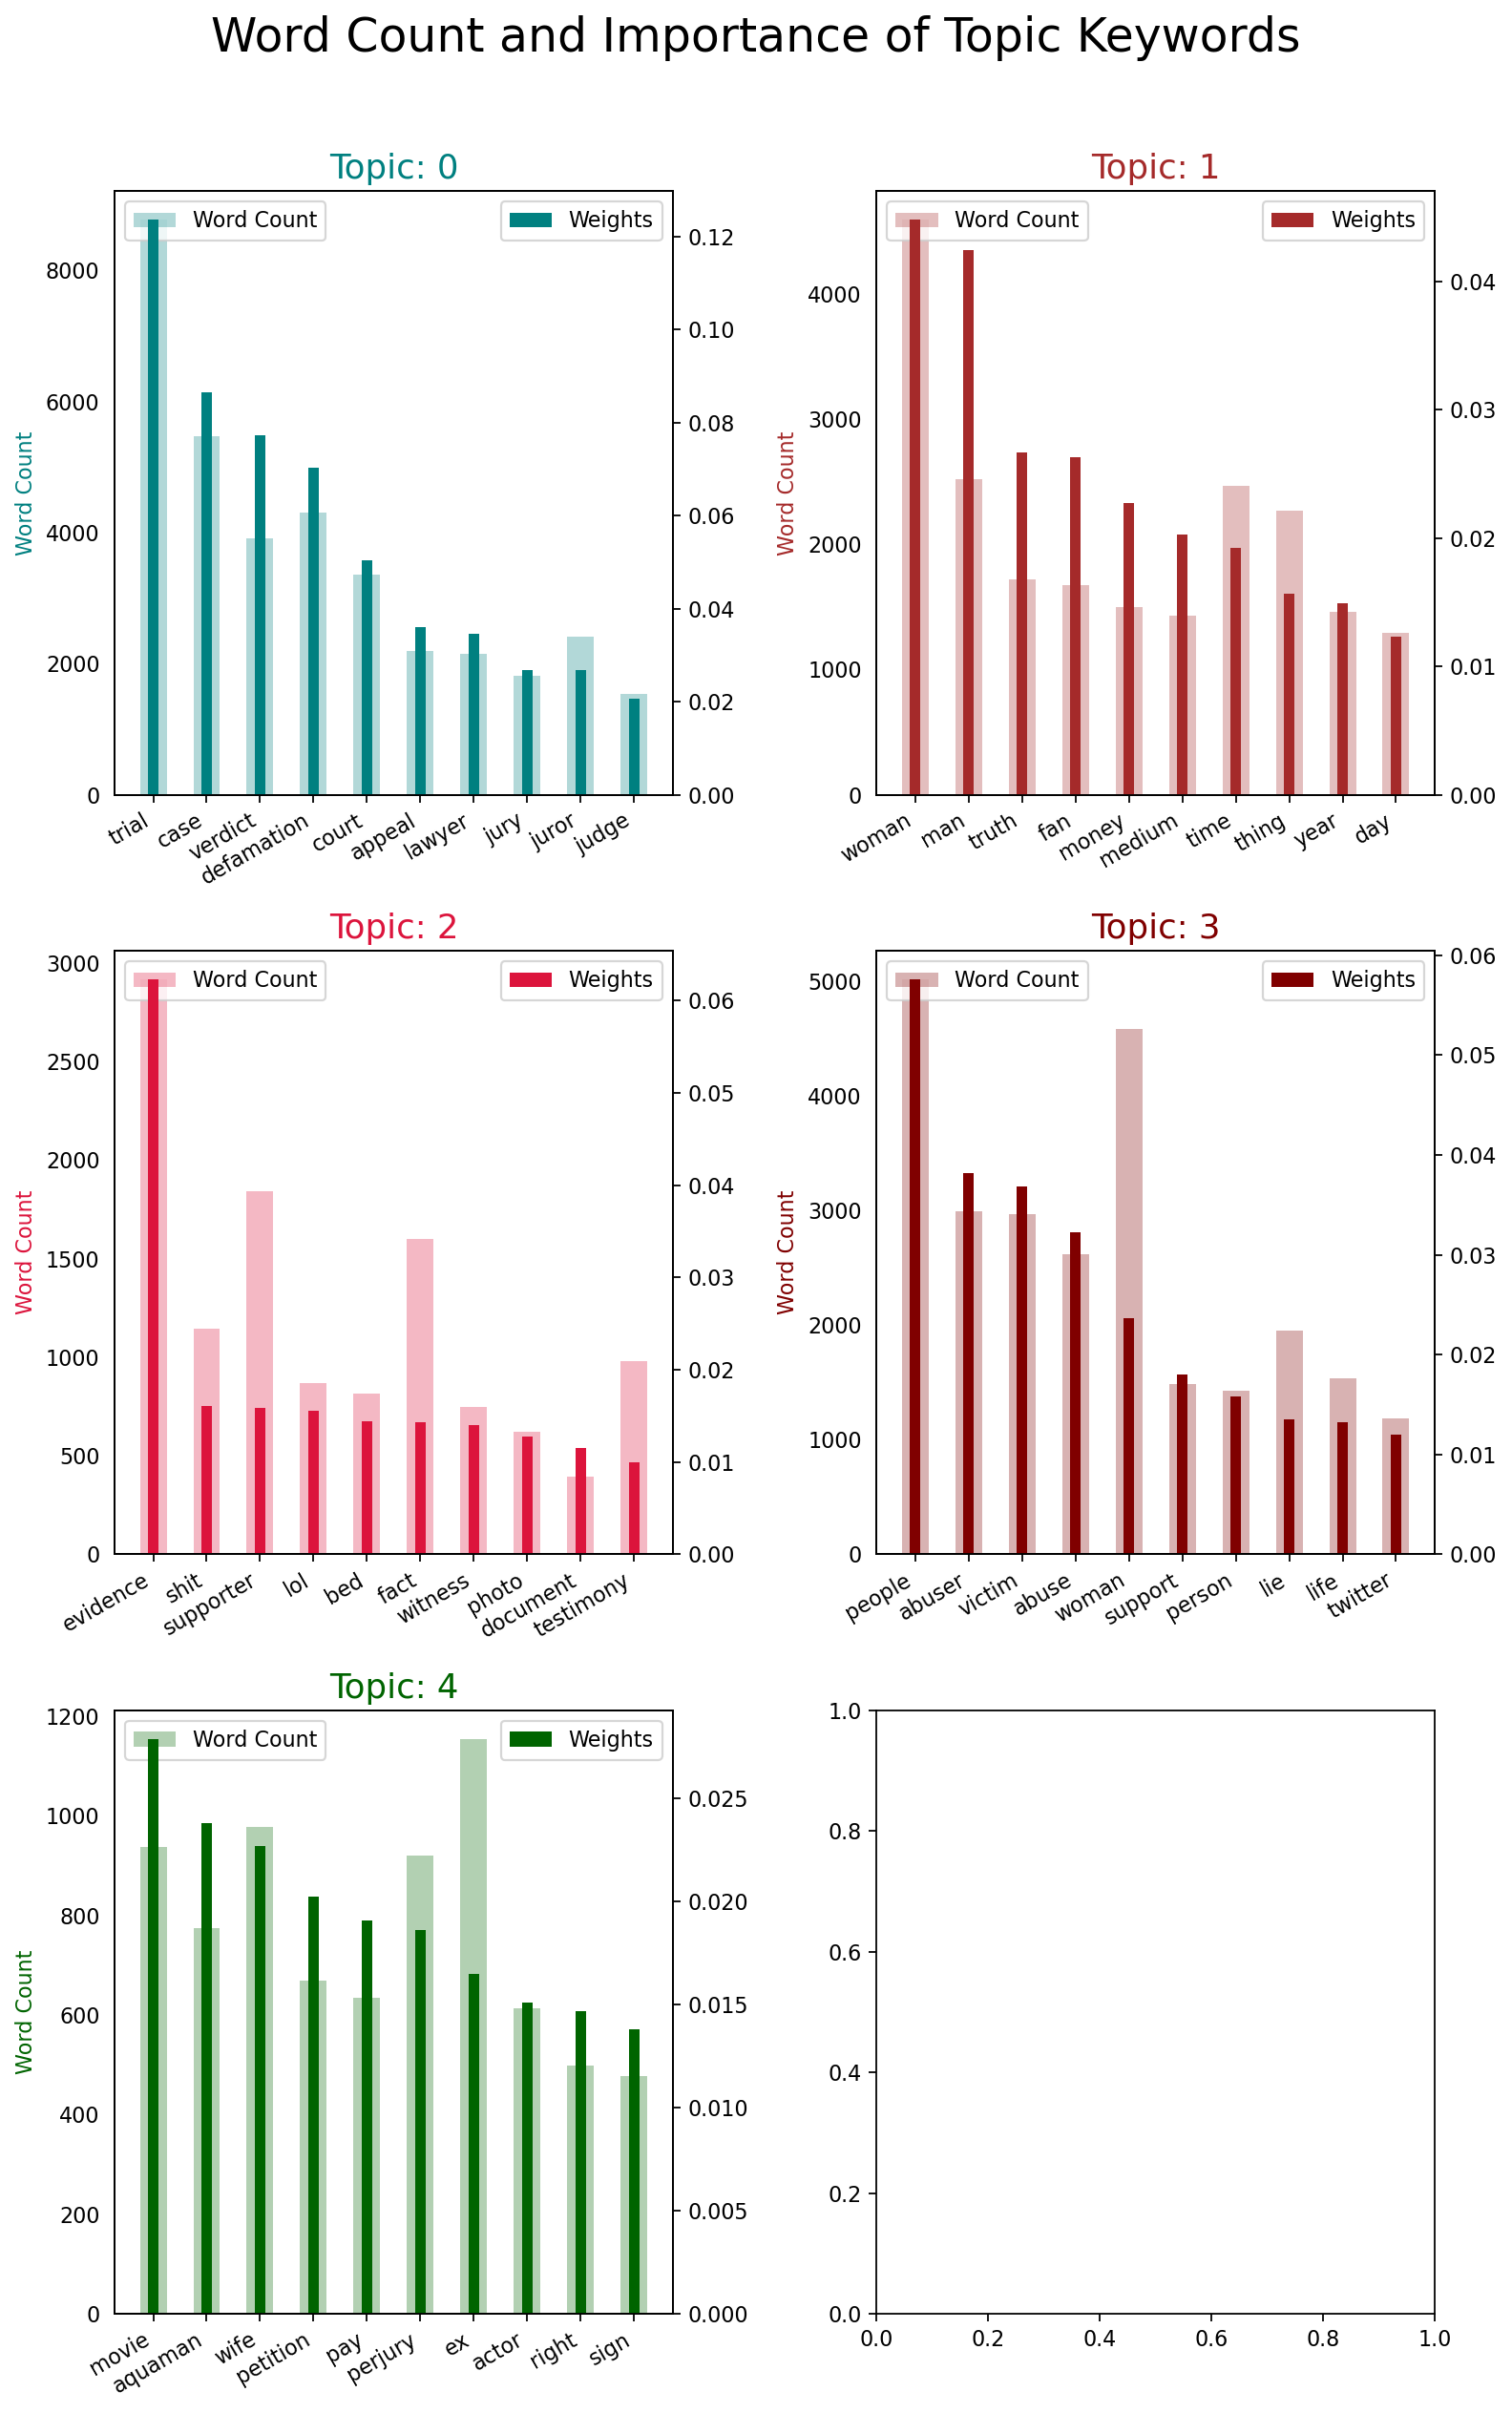

In [56]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
